# Tutorial 3: Interaction cutoffs and energy nonconservation

## Physics 7810, Spring 2020

## T3.1 - Truncation effects for interacting particles in a central force potential

In Tutorial 2, you wrote an MD simulation program for $N$ interacting particles in a central force potential. This simulation code had no interaction cutoff, so the cost of computing pair interactions was $O(N^2)$.

In this tutorial, we'll introduce interaction cutoffs, a step toward achieving $O(N)$ computational complexity, and we'll quantify the effects of pair potential truncation on energy conservation.

Modify your simulation code to introduce an interaction cutoff distance $r_c$, so that the pair interaction potential now has the form:

$$
u_{\rm int}(r_{ij}) = \left\{
\begin{array}{ll}
a r_{ij}^{-k}, & r_{ij} < r_c \\
0, & r_{ij} \geq r_c
\end{array}
\right..
$$

For this exercise, take $k = 6$ and assume that $a$ is positive (repulsive $r^{-6}$ pair interaction). Take the central force potential to be harmonic $n = 2$.

First, with no trunction of the pair potential, adjust the integration timestep and total kinetic energy so that very good energy conservation is achieved over long simulation times (this may require a judicious choice of initial conditions). Plot the total energy $E$ as a function of $t$ and measure the relative root-mean-squared (rms) fluctuation in total energy over the course of a long simulation, where the relative rms fluctuation in energy is defined as

$$
\frac{\langle \delta E^2 \rangle^{1/2}}{\langle E \rangle} = \frac{\langle (E - \langle E \rangle)^2 \rangle^{1/2}}{\langle E \rangle},
$$

and where the angle brackets denote a time average.

Recall that

$$
\langle \delta E^2 \rangle = \langle (E - \langle E \rangle)^2 \rangle = \langle E^2 - 2 E \langle E \rangle + \langle E \rangle^2 \rangle
= \langle E^2 \rangle - \langle E \rangle^2
$$

Now repeat this simulation for various values of $r_c$. Plot $E$ as a function of $t$ and measure $\langle \delta E^2 \rangle^{1/2} / \langle E \rangle$ for each value of $r_c$. What impact does potential truncation have on energy conservation? Does imposing an interaction cutoff lead to long-term energy drift?

### Solution

#### Problem 1: MD simulations without energy truncation

First, to see if the total energy is well-conserved without energy truncation, we perform a molecular dynamics simulation using the parameteris specified as follows:
```yml
# Simulation parameters
simulation: MD
N_particles: 4
N_steps: 1000
dt: 0.001
m: 1 # the mass of the particle (all the same)
n: 2 # the order of the total external energy
u: 1 # the coefficient of the total external energy
k: 6 # the order of the pairwise potential 
a: 1 # the coefficient of pariwise potential
r_c: 0 # the distance cutoff for the interaction potential
box_length: 3

print_freq: 1
dimension: 2
potential: 'central'
PBC: 'no'
coords_method: 'lattice'  
velo_method: 'random'
shift_energy: 'no'
energy_truncation: 'no'
```

Then, we import the library for performing MD simulations:

In [10]:
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

Given the parameters specified above and the molecular dynamics package, we conduct an MD simulation and calculate RMSF as follows:

The RMSF in the total energy is: 1.7895102074116676e-07


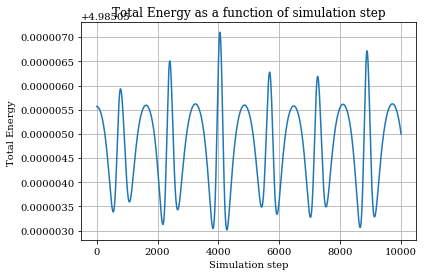

In [13]:
mdp = Initialization('Tutorial_03.yml')
MD = MolecularDynamics(mdp)
MD.verlet_integration(MD.velocities, MD.coords)
TA = TrajAnalysis(MD, 'Tutorial_03_traj.yml')
TA.plot_2d(TA.E_total, 'Total Energy')
RMSF = TA.calculate_RMSF(TA.E_total)
print('The RMSF in the total energy is: %s' % RMSF)

As a result, over a long simulation (10000 steps), the energy is still well-conserved, characteristic of a RMSF of $1.79 \times 10^{-7}$. However, an MD simulation without energy truncation is not computationally efficient. That's why we need to adopt the energy truncation method and estimate a reasonable cutoff distance that would have a small enough RMSF value in the next section.

#### Problem 2: Examination of various cutoff distances on the conservation of the total energy of the system

To quantify the influence of imposing potential truncation, we develop a method `quantify_cutoff` as below to calculate the RMSF of the trajectory of a MD simulation given the parameters specified in `Tutorial_03.yml`, as show below. 

In [14]:
def quantify_cutoff(r_c, plot=False, nsteps=None):
    mdp = Initialization('Tutorial_03.yml')
    MD = MolecularDynamics(mdp)
    MD.r_c = r_c
    if nsteps is not None:
        MD.N_steps = nsteps
    MD.verlet_integration(MD.velocities, MD.coords)
    TA = TrajAnalysis(MD, 'Tutorial_03_traj.yml')
    RMSF = TA.calculate_RMSF(TA.E_total)
    
    if plot is True:
        TA.plot_2d(TA.E_total, 'Total Energy')
        print('RMSF: %s' % RMSF)
    
    return RMSF

To observe the influence that energy trunaction has on the energy conservation, we plot the RMSF value as a function of cutoff distance. Here we first use a list of cutoff distance with a larger spacing to approximately locate the reasonable value of $r_c$. As shown below, a reasonable cutoff should be around 2.25.

Optimal cutoff distance:  2.25
RMSF corresponding to the optimal cutoff:  1.6283710896198073e-07


Text(0.5,1,'RMSF as a function of cutoff distance')

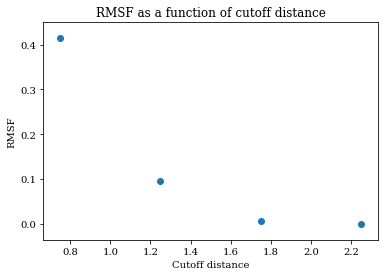

In [2]:
%matplotlib inline
r_c = np.arange(0.25, 2.51, 0.5)
RMSF = []
optimal_found = False

for i in r_c:
    rmsf = quantify_cutoff(i)
    RMSF.append(rmsf)
    if rmsf < 0.00001 and optimal_found is False and i != 0:
        optimal_found = True
        print('Optimal cutoff distance: ', i)
        print('RMSF corresponding to the optimal cutoff: ', rmsf)
    
plt.figure()
plt.scatter(r_c, RMSF)
plt.xlabel('Cutoff distance')
plt.ylabel('RMSF')
plt.title('RMSF as a function of cutoff distance')

To decrease the computational cost, we want to find a cutoff distance that is small, but still meets the requirement that RMSF is lower than 0.00001. Therefore, we decrease the spacing of the list of the cutoff distances which are slightly smaller than 2.25. As a result, at about $r_c=2.13$, the value of RMSF is only about $2.06 \times 10^{-7}$.

Optimal cutoff distance:  2.1299999999999994
RMSF corresponding to the optimal cutoff:  2.0619161338524686e-07


Text(0.5,1,'RMSF as a function of cutoff distance')

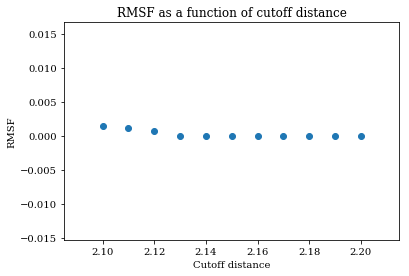

In [7]:
%matplotlib inline
r_c = np.arange(2.1, 2.21, 0.01)
RMSF = []
optimal_found = False

for i in r_c:
    rmsf = quantify_cutoff(i)
    RMSF.append(rmsf)
    if rmsf < 0.00001 and optimal_found is False and i != 0:
        optimal_found = True
        print('Optimal cutoff distance: ', i)
        print('RMSF corresponding to the optimal cutoff: ', rmsf)
    
plt.figure()
plt.scatter(r_c, RMSF)
plt.xlabel('Cutoff distance')
plt.ylabel('RMSF')
plt.title('RMSF as a function of cutoff distance')

Here, to see if the energy drifts away in a long simulation with cutoff distance of 2.13, we increase the number of steps from 1000 to 20000 as below.

RMSF: 0.0007662422408432521


0.0007662422408432521

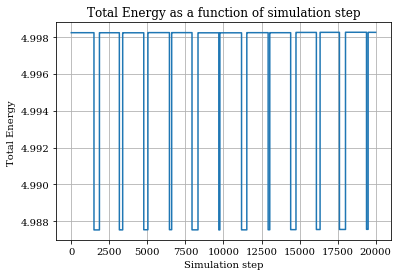

In [18]:
quantify_cutoff(2.13, plot=True, nsteps=20000)

As a result, the total energy is still well-conserved, charaerstic of a RMSF vaue of 0.00077. While the RMSF did increase, it is still a small value. Therefore, for a simulation less than 20000 steps, using a cutoff as 2.13 should be sufficiently reasonable. However, if a longer simulation is required, then a larger cutoff distance would be required.